# Reinforcement Learning Environment for Economic Market (Time Series)
This note book contains the RL environment for finance. We start with a base class for general finance problem. Then we use a derived class for a concrete environment for training.

In [1]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
import random
import sys
sys.path.append('../module')
from typing import Tuple
import matplotlib.pyplot as plt

from data_handler import get_econ_predictors, \
                         get_quarterly_date_format, \
                        get_monthly_date_format, \
                        get_equities_returns_volatility,\
                        get_equities_returns,\
                        get_env_data
%matplotlib inline

# RL Environment Base Class for General Finance
We firstly introduce a base class for general purpose. This idea is inspired by [gym-anytrading](https://github.com/AminHP/gym-anytrading/blob/296bae49e77d08a7c7349b542cdd00ea7ca23af0/gym_anytrading/envs/trading_env.py)

In [2]:
class TimeSeriesEnvBase(gym.Env):
    metadata = {"render_modes": "human"}

    def __init__(self):
        '''
        Initialize the environment.
        
        Description
        -----------
        We use the OpenAI gym.Env class as the parent class of our environment.
        Here we initialize some key properties of the environment.
        We set the observation space and action space for our environment using OpenAI Gym's space API.
        '''
        self.action_space = None
        self.state_space = None
        self.state = None
        self.reward = 0
        self.terminated = False
        self.info = {}

        self.start_tick = None
        self.end_tick = None
        self.current_tick = None

    def reset(self, seed=None):
        '''
        Reset the environment`s state. 
        Set the random seed once at the beginning of the experiment. 
        Then keep the same seed for the whole experiment.
        Also, we need to reset the state to the initial state.
        Clear the cumulative reward and other information.
        '''
        super().reset(seed=seed)
        state = None # reset the state to the initial state
        info = None

        return state, info

    def step(self, action):
        '''
        Take an action and return the next state, reward, done, info.
        We use the term "state" instead of "observation" in this function.
        The observation is the state plus some other information.
        The state is the representation of the environment.
        For research purpose, we want to keep the setting as simple as possible.
        Therefore, we only use the state as the input.
        '''

        state_prime = self._trans_func(action)
        reward = self._calculate_reward(action)
        terminated = self._is_terminated()
        info = self._get_info()

        return state_prime, reward, terminated, info
    
    def _trans_func(self, action):
        '''
        Move to the next state based on the current state and action.
        In the time series data, the transition is represented by the transition of the timestep.
        We get the timestep of current state and action value to calculate the next state.
        
        '''
        raise NotImplementedError

    def _calculate_reward(self, action):
        '''
        Since this class is built for time series data, the transition is represented by the transition of the timestep.
        Then we only need the timestep of state and action value to calculate the reward.
        '''
        raise NotImplementedError
    
    def _is_terminated(self):
        '''
        Check if the episode is terminated.
        '''
        raise NotImplementedError
    
    def _get_info(self):
        raise NotImplementedError
        
    

# RL Environment for Economic Market

The RL problem is summarized as follow:
\begin{equation}
\begin{aligned}
S &= \{ECON_1, ECON_2, \dots, ECON_{15}\} \\
A &= \{(w_1, w_2)|w_1, w_2 \in \mathbb{R}\} \\
R &= \log(PR)
\end{aligned}
\end{equation}

In [230]:
class EconMarketEnv(gym.Env):
    metadata = {"render_modes": "human"}
    """
    This class defines an OpenAI Gym environment for simulating a simple trading market.
    The market is modeled as a time series of econ factors.
    The environment is used for training trading agents to learn how to select and manage a portfolio of equities.

    The EconMarketEnv class is an implementation of the OpenAI Gym Env class.
    It has two main functions:
        - reset: reset the environment to its initial state and return the first observation
        - step: take an action, update the state of the environment, and return the new observation, reward, done, and info.

    The environment's state is a vector of econ factors, representing the market at a particular point in time.
    The observation is the state vector plus some additional information, (TBD).
    The action is a vector representing the portfolio weights for each equity.
    The reward is computed based on the portfolio returns.
    The environment is considered "done" if the episode reaches the last tick of the data.
    """

    def __init__(self, data: pd.DataFrame, portfolio: pd.DataFrame, features: dict):
        """
        Initialize the environment.

        Parameters
        ----------
        data : pandas.DataFrame
            The input time series data of econ factors.
        portfolio : pandas.DataFrame
            The portfolio time series of each individual equity return.

        Description
        -----------
        We set the observation space and action space for our environment using OpenAI Gym's space API.
        We also convert the data and portfolio to numpy arrays for performance reasons.
        """
        super(EconMarketEnv, self).__init__()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(18,),dtype=np.float64)
        self.action_space = spaces.Box(low=-1, high=1, dtype=np.float64)
        self.data = data.values
        self.index = data.index
        self.portfolio = portfolio.values
        self.features = features
        self.equitites_vol = self.features['volatility'].values

        self.start_tick = 0
        self.end_tick = data.shape[0] - 2
        self.current_tick = None
        
        self.total_reward = 0
        self.port_ret = 0
        self.terminated = False
        self.info = {}
        self.reward = 0.0

        self.gamma = 1

    def reset(self, seed=None):
        '''
        Reset the environment's state. 
    
        Parameters
        ----------
        seed : int, optional
            Random seed for the experiment, by default None.
        
        Returns
        -------
        state : ndarray
            The initial state of the environment.
        info : dict
            A dictionary of additional information for the initial state.

        Notes
        -----
        Set the random seed once at the beginning of the experiment. 
        Then keep the same seed for the whole experiment.
        '''
        super().reset(seed=seed)
        self.current_tick = self.start_tick
        state = self.data[self.current_tick]
        state = np.append(state, [0.5, 0.5, 0.0]) # add weights and portfolio return

        self.reward = 0.0
        self.total_reward = 0.0
        self.terminated = False
        self.port_ret = 0.0
        self.info = {}

        return state
    
    def step(self, action):
        '''
        Takes an action and returns the next state, reward, done, info.

        Parameters:
        -----------
        state : numpy.ndarray
            The current state of the environment.
        action : int
            The action taken by the agent.

        Returns:
        --------
        state_prime : numpy.ndarray
            The next state of the environment.
        reward : float
            The reward received by the agent.
        terminated : bool
            True if the episode is over, False otherwise.
        info : dict
            A dictionary containing any additional information about the transition.

        Notes:
        ------
        We use the term "state" instead of "observation" in this function.
        The observation is the state plus some other information.
        The state is the representation of the environment.
        For research purposes, we want to keep the setting as simple as possible.
        Therefore, we only use the state as the input.
        '''
        self.terminated = self._is_terminated()
        self.reward = self._calculate_reward(action)
        state_prime = self._trans_func(action)
        info = self._get_info()
        self.total_reward += self.reward

        return state_prime, self.reward, self.terminated, info

    
    def _trans_func(self, action):
        '''
        Move to the next state based on the current state and action.

        Parameters:
        ----------
        state : ndarray
            A numpy array that represents the current state of the environment.
        action : float
            An float that represents the action taken by the agent.

        Returns:
        -------
        state_prime : ndarray
            A numpy array that represents the next state of the environment.

        Description:
        ------------
        In the time series data, the transition is represented by the transition of the timestep.
        We get the timestep of current state and action value to calculate the next state.    
        '''
        state_prime = self.data[self.current_tick + 1]
        state_prime = np.append(state_prime, [action[0], 1 - action[0], np.sign(self.reward)])
        self.current_tick += 1

        return state_prime
        
    def _calculate_reward(self, action):
        '''
        Calculate the reward based on the current state and action.
        
        Parameters
        ----------
        state : numpy array
            The current state of the environment.
        action : numpy array
            The action taken by the agent.

        Returns
        -------
        float
            The reward for the current state and action.
        
        Description:
        ------------
        For time series data, the transition is represented by the transition of the timestep.
        We get the timestep of current state and action value to calculate the reward.
        We need wait untile the next timestep to get the equity return.
        Then we calculate the reward by the portfolio weight and the equity return.
        '''
        w = np.array([action, 1 - action]).reshape(-1,)
        self.port_ret = w @ self.portfolio[self.current_tick + 1]
        port_std = self.equitites_vol[self.current_tick + 1]
        utility = self.port_ret - self.gamma * w ** 2 @ port_std ** 2
        # reward = np.log(self.port_ret + 1)
    
        return utility

    def _is_terminated(self):
        '''
        Check if the episode is terminated.
        
        Returns
        -------
        bool
            True if the episode is terminated, False otherwise.
        
        Description:
        ------------
            An episode is terminated if the current tick is equal to the end tick.
        '''
        return self.current_tick == self.end_tick

    def _get_info(self):
        return {'portfolio return': self.port_ret, 'date': self.index[self.current_tick]}

# Test the environment

prepare the data to construct the environment

In [16]:
def get_env_data(start_date: str, end_date: str, data_freq: str = 'quarterly') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Retrieve economic predictors, equities returns, and equities returns volatility data within the specified dates.

    Parameters:
    -----------
    start_date : str
        The start date in 'YYYY' format.
    end_date : str
        The end date in 'YYYY' format.
    data_freq : str
        The frequency of the data, either 'quarterly' or 'monthly'.

    Returns:
    --------
    A tuple of the following:
        - A data frame containing the economic predictors within the specified dates
        - A series of equities returns within the specified dates
        - A series of equities returns volatility within the specified dates
    """
    data = get_econ_predictors(data_freq=data_freq, START_DATE=start_date, END_DATE=end_date)
    data.pop('Equity Premium')
    equities_returns = get_equities_returns(data_freq=data_freq)
    equities_returns_vol = get_equities_returns_volatility(data_freq=data_freq)

    data = data.loc[start_date:end_date]
    index = data.index
    equities_returns = equities_returns.loc[index]
    equities_returns_vol = equities_returns_vol.loc[index]

    return data, equities_returns, equities_returns_vol


In [14]:
data, equities_returns, equities_returns_vol = get_env_data('1947', '1951')

In [3]:
from RL_env import EconMarketEnv
env_test = EconMarketEnv(data, equities_returns, {'volatility': equities_returns_vol})

Test the constructor of the environment class

In [13]:
print(env_test.data.shape)
print(env_test.portfolio.shape)
print(env_test.index)
print(env_test.start_tick)
print(env_test.end_tick)
print(env_test.current_tick)
print(env_test.total_reward)
print(env_test.terminated)
print(env_test.reward)
print(env_test.info)

(21, 15)
(24, 2)
PeriodIndex(['2000-03', '2000-06', '2000-09', '2000-12', '2001-03', '2001-06',
             '2001-09', '2001-12', '2002-03', '2002-06', '2002-09', '2002-12',
             '2003-03', '2003-06', '2003-09', '2003-12', '2004-03', '2004-06',
             '2004-09', '2004-12', '2005-03'],
            dtype='period[M]')
0
19
None
0
False
0.0
{}


Test the rest() function

In [53]:
print(env_test.reset(100))
print(env_test.current_tick)
print(env_test.total_reward)
print(env_test.terminated)
print(env_test.np_random.__getstate__())
print(env_test.reset())
print(env_test.np_random.__getstate__())

[-4.49315885 -4.47339293 -3.38142851 -1.11173034  0.01488508  0.14997356
  0.01829139  0.0569      0.0618      0.08832965  0.0049      0.0069
 -0.06422931  0.01723113  0.04337264  0.5         0.5         0.        ]
0
0
False
{'bit_generator': 'PCG64', 'state': {'state': 241834680195789509926839563169936010333, 'inc': 30008503642980956324491363429807189605}, 'has_uint32': 0, 'uinteger': 0}
[-4.49315885 -4.47339293 -3.38142851 -1.11173034  0.01488508  0.14997356
  0.01829139  0.0569      0.0618      0.08832965  0.0049      0.0069
 -0.06422931  0.01723113  0.04337264  0.5         0.5         0.        ]
{'bit_generator': 'PCG64', 'state': {'state': 241834680195789509926839563169936010333, 'inc': 30008503642980956324491363429807189605}, 'has_uint32': 0, 'uinteger': 0}


Test the step() function

In [74]:
action = np.array([0])
state_prime = env_test.step(action)
print(state_prime)
print(env_test.port_ret)
print(env_test.current_tick)
print(env_test.total_reward)
print(env_test.terminated)


IndexError: index 21 is out of bounds for axis 0 with size 21

Test the environment as a whole

In [5]:
env = EconMarketEnv(data, equities_returns, {'volatility': equities_returns_vol})  # create an instance of your environment
np.random.seed(1234)  # set the random seed to 1234
random.seed(1234)  # set the random seed to 1234

# reset the environment to get the initial state
state = env.reset(1234)
done = False  # whether the episode is done
total_reward = 0  # the total reward earned during the episode

while not done:
    # randomly select an action from the action space
    action = env.action_space.sample()

    # take a step in the environment with the selected action
    next_state, reward, done, info = env.step(action)

    total_reward += reward  # accumulate the reward

print(f'Total reward: {total_reward}')


Total reward: -0.10317679779705956


Make the environment compatible with stable-baselines3

In [6]:
from stable_baselines3.common.env_checker import check_env

In [7]:
check_env(env)

Train SB3 agent on the environment

In [77]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C, TD3

# Create environment
env = EconMarketEnv(data, equities_returns, {'volatility': equities_returns_vol})

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="../../log/tensorboard_reward_utility/")

# Train the agent and display a progress bar
model.learn(total_timesteps=int(2e5), progress_bar=True)

model.save("../../log/model/ppo_reward_utility")


Output()

# Extract action information from training period

In [2]:
from RL_env import EconMarketEnv
from stable_baselines3 import PPO

data, equities_returns, equities_returns_vol = get_env_data('1965', '1969')
env = EconMarketEnv(data, equities_returns, {'volatility': equities_returns_vol})
model = PPO("MlpPolicy", env, tensorboard_log="../../log/tensorboard_reward_utility/", verbose=0)
model = model.learn(int(2e5), progress_bar=True)
model.save("../../log/model/ppo_reward_utility")
# del model

Output()

In [4]:

# env = EconMarketEnv(data, equities_returns, {'volatility': equities_returns_vol})
#model = PPO.load("../../log/model/ppo_reward_utility", env=env)
state = env.reset()
done = False 
total_reward = 0  
action_list = []
port_ret_list = []
date_list = []
while not done:
    action, _states = model.predict(state, deterministic=False)
    next_state, reward, done, info = env.step(action)
    total_reward += reward 
    action_list.append(action[0])
    port_ret_list.append(info['portfolio return'])
    date_list.append(info['date'])

print(f'Total reward: {total_reward}')

Total reward: 0.12008318091684456


In [5]:
performance = pd.DataFrame({'action': action_list, 'portfolio return': port_ret_list}, index=date_list)
performance.index = performance.index.asfreq('Q')
performance

,action,portfolio return
1965Q3,1.0,0.069425
1965Q4,1.0,0.027457
1966Q1,1.0,-0.034621
1966Q2,1.0,-0.050319
1966Q3,1.0,-0.096531
1966Q4,1.0,0.049242
1967Q1,1.0,0.122868
1967Q2,1.0,0.004878
1967Q3,1.0,0.066968
1967Q4,1.0,-0.002482


The action is take at time t, the reward and portfolio return is recieved at time t+1. For simplicity, we put the action at time t and portfolio return at time t+1 at the same row.

# Agent & Environment Trouble shooting

By looking into the test of RL agent and Econ Market Envrionment, we find several wired things need to be solved:

- The action always converge to 1 or -1. It seems that the agent doesn't learn too much.
- Unmatching total rewards. After trained on a data period, we test the well trained agent on the same data. The total reward received from testing is always smaller than the total reward form training.
- The randomness of agent action.
- Hyper-parameter tunning
  - discount factor
  - penalty in the reward
  - num of year in the objectives
  - state space (regime - POMDP)

# Performance Evaluation

The RL agent output action (weights for risky asset) at each time step. We also record the portfolio return at each time step. We want to evaluate the agent's action according to the portfolio return. We gather the agent's action, the portfolio's return time series and the benchmark's return togather. We compare the agent's performance against benchmark in terms of portfolio return, utility and risk-adjust return.

In [8]:
def evaluate_agent_action(df: pd.DataFrame) -> Tuple[float, plt.Figure, pd.DataFrame]:
    """
    Calculates the Sharpe ratio for the portfolio returns in the given data frame.

    Parameters:
        df: A pandas DataFrame containing 'action' and 'portfolio return' columns.

    Returns:
        A tuple containing the Sharpe ratio, a figure object, and the performance DataFrame.
        The performance DataFrame contains the 'portfolio return', 'benchmark 60/40', 'Market Index',
        and 'Rfree' columns, which are used to calculate the Sharpe ratio and plot the cumulative
        returns.
        
    Raises:
        ValueError: If the input portfolio return does not match the calculated portfolio return.
    """
    action = df['action'].values
    portfolio_return_input = df['portfolio return'].values
    equities_returns = get_equities_returns(data_freq='quarterly')
    equities_returns.index = equities_returns.index.asfreq('Q')
    index = df.index.asfreq('Q')
    equities_returns = equities_returns.loc[index].values

    w = np.column_stack([action, 1 - action])
    portfolio_return = np.sum(equities_returns * w, axis=1)
    if not np.array_equal(portfolio_return_input, portfolio_return):
        raise ValueError("Input portfolio return does not match the calculated portfolio return.")

    benchmark_60_40 = equities_returns @ np.array([0.6, 0.4])
    performance = pd.DataFrame(columns=['portfolio return', 'benchmark 60/40', 'Market Index', 'Rfree'],
                               data=np.column_stack([portfolio_return, benchmark_60_40, equities_returns]))

    fig, ax = plt.subplots()
    performance.cumsum().plot(ax=ax)
    ax.set(title='RL vs Benchmark', ylabel='Cumulative Returns')

    sharpe_ratio = np.mean(performance[['portfolio return', 'benchmark 60/40']]) \
                    / np.std(performance[['portfolio return', 'benchmark 60/40']])
    
    return sharpe_ratio, fig, performance


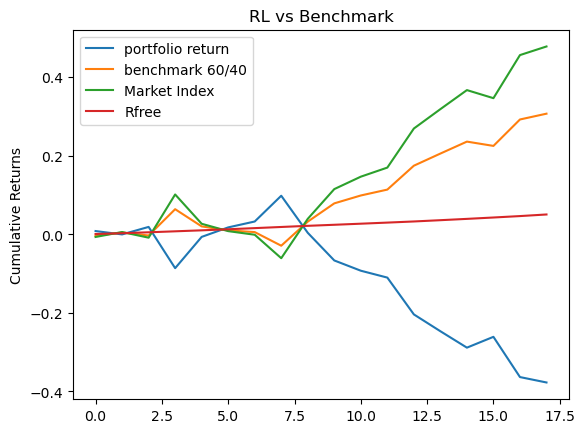

In [9]:
a, b, c = evaluate_agent_action(performance)

In [10]:
a

portfolio return   -0.383279
benchmark 60/40     0.517110
dtype: float64

# Moving Training
We use 5 years data to train the RL agent. That means the algo is maximizing the 5 years total rewards rather than the whole period. Once the agent is well trained on the 5 years data, we move one quarter ahead and repeat the same thing until the end of sample period. Finally, we get a well trained agent that maximizing 5 years total reward and include whole sample information.

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from stable_baselines3 import PPO, A2C, TD3
from tqdm import tqdm

In [22]:
from sklearn.model_selection import TimeSeriesSplit
DATA_FREQUENCY = 4
WINDOW_SIZE = 5
SAMPLE_SIZE = data.shape[0]
tscv = TimeSeriesSplit(n_splits = SAMPLE_SIZE - DATA_FREQUENCY * WINDOW_SIZE - 1,
                       test_size=1, 
                       max_train_size= DATA_FREQUENCY * WINDOW_SIZE)

In [25]:
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(data))):
    env = EconMarketEnv(data.iloc[train_index], portfolio.iloc[train_index])
    
    if i == 0:
        model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="../../log/tensorboard_econmarket/")
    else:
        model = PPO.load("../../log/model/ppo_econmarket", env=env)

    model.learn(int(2e5))
    model.save("../../log/model/ppo_econmarket")

28it [30:08, 64.58s/it]


KeyboardInterrupt: 